**OG EDIT**
- For the purposes of my own project, I'll be using our Pikh1 HMA-AVR-PikC binding dataset. This will be formatted as detailed in metl/data/dms_data/README.md.

# Generate splits for an experimental dataset
This notebook shows how to generate splits for an experimental dataset, using the avGFP dataset as an example.

You can generate multiple types of splits.
- A "super test" or withholding split. It's a simple random sample of variants meant to be completely held out until the final model training and evaluation.
- Classic train, validation, and test splits based on percentages of the total dataset.
- Reduced dataset sizes for evaluating performance as a function of training set size.
- Extrapolation splits (mutation, position, score, and regime extrapolation) for testing the generalization performance of the models.


This example generates a single replicate of each type of split, but it is recommended to use multiple replicates in practice.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# 1. Get the absolute path of the directory containing the current script.
#    This will be your '01_finetune_metl_global' folder.
current_dir = os.getcwd()

# 2. Get the parent directory of your current script's folder.
#    This will be the top-level 'metl' directory that contains both of your folders.
parent_dir = os.path.dirname(current_dir)

# 3. Construct the path to the sibling 'metl' repo's 'code' folder.
module_path = os.path.join(parent_dir, "metl", "code")

# 4. Add the module path to the system path so imports work.
if module_path not in sys.path:
    sys.path.append(module_path)

# You can add a print statement to confirm it's working correctly
print(f"Added to sys.path: {module_path}")

Added to sys.path: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/code


In [3]:
import random
import split_dataset as sd
import utils

In [4]:
import logging
logging.basicConfig()
logger = logging.getLogger("METL")
logger.setLevel(logging.INFO)

# Prepare FACS data in expected format

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
csv_path = os.path.join(parent_dir,'yeast_data','avrpikC_full.csv')
df = pd.read_csv(str(csv_path))
df.head()

,aa_sequence,enrichment_score
0,GLKQKIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRDKIEV...,1.468796
1,GLKRIIVIKVAREGNNCRSKAMALVASTGGVDSVALVGDLRGKIEV...,1.415944
2,GLKRIIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRGKIEV...,1.389615
3,GLKQKIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRDKIEV...,1.359651
4,GLKQKIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRGKIEV...,1.343857


In [14]:
def identify_mutations(reference_seq, mutant_seq):
    """
    Compares a mutant sequence to a reference sequence and identifies mutations.

    Args:
        reference_seq (str): The wild-type amino acid sequence.
        mutant_seq (str): The mutant amino acid sequence.

    Returns:
        tuple: A tuple containing:
            - str: A comma-separated string of mutations (e.g., "K2E,A11E").
            - int: The total number of mutations.
    """
    mutations = []
    # Use zip to iterate through both sequences simultaneously.
    # The position is 1-indexed for standard mutation notation.
    for i, (wt_aa, mut_aa) in enumerate(zip(reference_seq, mutant_seq)):
        if wt_aa != mut_aa:
            # Format the mutation string: [WT_AA][Position (0-indexed)][Mutant_AA]
            mutation_str = f"{wt_aa}{i}{mut_aa}"
            mutations.append(mutation_str)
            
    if not mutations:
        return "WT", 0
        
    return ",".join(mutations), len(mutations)

In [15]:
# --- Data Transformation ---
wt_sequence = "GLKQKIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRDKIEVVGYGIDPIKLISALRKKVGDAELLQVSQAKKD"

# 1. Apply the function to each row of the DataFrame.
#    This creates two new temporary Series containing the mutation strings and their counts.
mutations_info = df['aa_sequence'].apply(lambda seq: identify_mutations(wt_sequence, seq))

# 2. Create the new columns in the DataFrame.
df['variant'] = mutations_info.apply(lambda x: x[0])
df['num_mutations'] = mutations_info.apply(lambda x: x[1])

# 3. Rename the 'enrichment_score' column to 'score' for the final output.
df.rename(columns={'enrichment_score': 'score'}, inplace=True)

# 4. Create the final DataFrame with the desired columns in the correct order.
output_df = df[['variant', 'num_mutations', 'score']]


# --- Output ---

# Display the first few rows of the transformed data
print("--- Transformed Data Preview ---")
print(output_df.head())

# Save the final DataFrame to a tab-separated values (TSV) file.
# The `index=False` argument prevents pandas from writing the DataFrame index to the file.
output_filename = 'pikh1.tsv'
output_df.to_csv(output_filename, sep='\t', index=False)

print(f"\nSuccessfully created '{output_filename}'")

--- Transformed Data Preview ---
             variant  num_mutations     score
0          Q73R,A74V              2  1.468796
1  Q3R,K4I,M11R,D41G              4  1.415944
2       Q3R,K4I,D41G              3  1.389615
3          E67K,D77G              2  1.359651
4          D41G,D65N              2  1.343857

Successfully created 'pikh1.tsv'


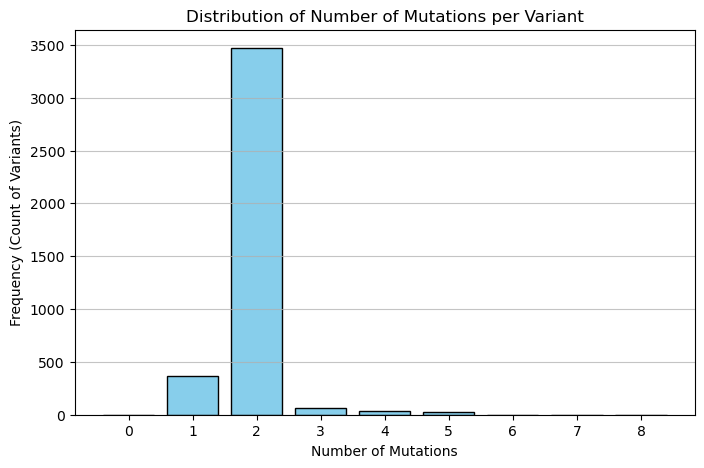

In [14]:
# Determine the range for bins to ensure each integer has its own bar
max_mutations = output_df['num_mutations'].max()
bins = range(int(max_mutations) + 2) # e.g., if max is 3, bins will be [0, 1, 2, 3, 4]

plt.figure(figsize=(8, 5))
plt.hist(output_df['num_mutations'], bins=bins, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Mutations per Variant')
plt.xlabel('Number of Mutations')
plt.ylabel('Frequency (Count of Variants)')
plt.xticks(bins[:-1]) # Set ticks to be the integer values
plt.grid(axis='y', alpha=0.75)
plt.show()

# Rosettafy PDB

In [1]:
import os
import sys
import argparse
from pathlib import Path

In [5]:
# --- 1. Define Your Paths ---
# IMPORTANT: You MUST update these paths to match your system's setup.

# Path to your Rosetta installation.
# Example: '/home/user/rosetta/rosetta_src_2021.16.61629_bundle/main'
ROSETTA_MAIN_DIR = os.path.expanduser("~/rosetta/main/")

# Path to the raw PDB file you want to process.
# This should be the full path to the file.
# Example: '/home/user/metl_project/metl-sim/pdb_files/1gfl.pdb'
INPUT_PDB_FN = '/home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global/inputs/h1-C_af3.pdb'

# Specify the chain you want to keep from the PDB file.
# 'ignorechain' will keep all chains.
CHAIN_TO_KEEP = 'A'
# The base directory where you want the output folders to be created.
# A new timestamped subfolder will be created here.
# Example: '/home/user/metl_project/01_finetune_metl_global/prepared_pdbs'
OUTPUT_DIR_BASE = "/home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global/rosettafy_output"

# --- 2. Set up the Environment to Find the Script ---

# Get the directory of the sibling 'metl-sim' folder
# This assumes your notebook is in '01_finetune_metl_global'
current_dir = Path(os.getcwd())
metl_sim_dir = current_dir.parent / 'metl-sim'
prepare_script_dir = metl_sim_dir / 'code'

# Add the script's directory to the Python path to allow importing
if str(prepare_script_dir) not in sys.path:
    sys.path.insert(0, str(prepare_script_dir))

# Import the main function from the prepare.py script
try:
    from prepare import main as run_prepare_pdb
except ImportError as e:
    print(f"Error: Could not import the prepare script.")
    print(f"Please ensure the path '{prepare_script_dir}' is correct.")
    raise e

In [6]:
# --- 3. Create Mock Arguments and Run the Script ---

# The prepare.py script expects to be run from its own directory to find templates.
# We will temporarily change the working directory.
original_wd = os.getcwd()
os.chdir(metl_sim_dir)
print(f"Temporarily changed working directory to: {metl_sim_dir}")

try:
    # Create a namespace object to simulate command-line arguments
    args = argparse.Namespace(
        rosetta_main_dir=ROSETTA_MAIN_DIR,
        pdb_fn=INPUT_PDB_FN,
        keep_ligand=False,  # Set to True if your PDB has a ligand you want to keep
        chain=CHAIN_TO_KEEP,
        relax_nstruct=10,   # Number of structures to generate during relax
        out_dir_base=OUTPUT_DIR_BASE,
        conda_pack_env=None # Set to a path if you use conda-pack, otherwise leave as None
    )
    
    # Make sure the output directory exists
    os.makedirs(OUTPUT_DIR_BASE, exist_ok=True)

    print("\n--- Starting PDB Preparation ---")
    print(f"Input PDB: {args.pdb_fn}")
    print(f"Rosetta Directory: {args.rosetta_main_dir}")
    print("This process may take several minutes...")

    # Run the main function from the prepare.py script
    run_prepare_pdb(args)

    print("\n--- PDB Preparation Finished Successfully! ---")
    print(f"Check the '{OUTPUT_DIR_BASE}' directory for your prepared PDB file.")

except RuntimeError as e:
    print("\n" + "="*50)
    print("!!! An error occurred during the PDB preparation process !!!")
    print("="*50)
    print("The 'prepare.py' script reported a failure. This is often caused by an issue with the")
    print("Conda environment or the input PDB file. Here is the log from the failed step:")
    
    try:
        # Find the most recently created output directory to locate the log file
        output_dirs = [d for d in os.listdir(OUTPUT_DIR_BASE) if os.path.isdir(os.path.join(OUTPUT_DIR_BASE, d))]
        latest_dir = max(output_dirs, key=lambda d: os.path.getmtime(os.path.join(OUTPUT_DIR_BASE, d)))
        log_file_path = os.path.join(OUTPUT_DIR_BASE, latest_dir, 'working_dir', 'clean_pdb.out')

        if os.path.exists(log_file_path):
            print(f"\n--- Contents of {log_file_path} ---\n")
            with open(log_file_path, 'r') as f:
                print(f.read())
            print("--- End of Log ---")
        else:
            print(f"\nCould not find the log file at: {log_file_path}")

    except Exception as log_e:
        print(f"\nCould not retrieve the log file. Error: {log_e}")
    
    # Re-raise the original exception to show the full traceback
    raise e

finally:
    # IMPORTANT: Change back to the original directory
    os.chdir(original_wd)
    print(f"\nRestored working directory to: {original_wd}")

Temporarily changed working directory to: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl-sim

--- Starting PDB Preparation ---
Input PDB: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global/inputs/h1-C_af3.pdb
Rosetta Directory: /home/oscar/rosetta/main/
This process may take several minutes...
output directory is: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global/rosettafy_output/h1-C_af3_2025-07-02_15-26-15
Found 10 structures with lowest energy (-193.781).

--- PDB Preparation Finished Successfully! ---
Check the '/home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global/rosettafy_output' directory for your prepared PDB file.

Restored working directory to: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/01_finetune_metl_global


- pikh1.tsv was transfered to metl/data/dms_data/pikh1.
- the following was added to datasets.yml:

```
pikh1:
  ds_name: pikh1
  ds_dir: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/data/dms_data/pikh1
  ds_fn: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/data/dms_data/pikh1/pikh1.tsv
  wt_aa: GLKQKIVIKVAMEGNNCRSKAMALVASTGGVDSVALVGDLRDKIEVVGYGIDPIKLISALRKKVGDAELLQVSQAKKD
  wt_ofs: 0
  pdb_fn: h1-C_rcsb_cut.pdb
  rosettafy_pdb_fn: h1-C_rcsb_cut_p.pdb
```

# Load the dataset

In [11]:
ds_name = "pikh1_af3"
ds = utils.load_dataset(ds_name)

# some additional info needed for extrapolation splits
datasets = utils.load_dataset_metadata()
seq_len = len(datasets[ds_name]["wt_aa"])
wt_ofs = datasets[ds_name]["wt_ofs"]

# Withhold a "super test" set

I recommend having a completely held-out "super test" set. Don't use this set for development of the algorithm and don't look at evaluation results on this set until the very end, when you are ready to publish. Here we will create a super test set for avgfp and save it to the avgfp splits directory [data/avgfp/splits](../data/avgfp/splits).



In [12]:
out_dir = "data/dms_data/pikh1/splits/"

# use a fixed random seed for demonstration purposes
# rseed = random.randint(1000, 9999)
rseed = 5958

supertest_idxs, supertest_fn = sd.supertest(ds, size=.1, rseed=rseed, out_dir=out_dir, overwrite=True)
supertest_fn

INFO:METL.split_dataset:saving supertest split to file data/dms_data/pikh1/splits/supertest_w199b2a43b1ed_s0.1_r5958.txt


'data/dms_data/pikh1/splits/supertest_w199b2a43b1ed_s0.1_r5958.txt'

# Standard train, validation, and test splits

This will randomly sample train, validation, and test splits from the full dataset. You must specify the size of each set as a fraction of the total number of examples.

In [13]:
out_dir = "data/dms_data/pikh1/splits/standard"

# specify the super test set from above
# this set will be withheld from this train test split
withhold_fn = "data/dms_data/pikh1/splits/supertest_w240f09807a82_s0.1_r5958.txt"

# specify 80% train, 10% validation, and 10% test sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1

# multiple replicate splits
replicates = 1

# random seeds
# rseeds = [random.randint(1000, 9999) for _ in range(replicates)]
# for purposes of this demo, make the rseeds constant
rseeds = [3597]

for rseed in rseeds:    
    split, out_dir_split = sd.train_val_test(ds, 
                                             train_size=train_size, 
                                             val_size=val_size, 
                                             test_size=test_size, 
                                             withhold=withhold_fn, 
                                             out_dir=out_dir, 
                                             rseed=rseed, 
                                             overwrite=True)

INFO:METL.split_dataset:saving train-val-test split to directory data/dms_data/pikh1/splits/standard/standard_tr0.8_tu0.1_te0.1_w240f09807a82_r3597


# Resampled dataset sizes

This splits enable you to evaluate performance as a function of train size.

In [14]:
out_dir = "data/dms_data/pikh1/splits/resampled"
withhold_fn = "data/dms_data/pikh1/splits/supertest_w240f09807a82_s0.1_r5958.txt"

# specify the dataset sizes and number of replicates per dataset size
dataset_sizes = [10, 20, 40, 80, 160, 320, 640, 1280, 2560]
# just one replicate for each dataset size for this example
replicates = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# use multiple replicates in practice
# replicates = [101, 23, 11, 11, 11, 11, 7, 7, 5, 5, 3, 3]

# rseed = random.randint(1000, 9999)
rseed = 8099

# the test set is sampled from the full dataset
test_fraction = 0.1

# the validation set is sampled from the reduced dataset size
# the train set will be 1 minus the validation fraction
# so in this case, the train set will be 80%, and the validation set 20%
val_fraction = 0.2

# create the suite of resampled dataset size splits
for ds_size, reps in zip(dataset_sizes, replicates):
    splits, reduced_split_dir = sd.resampled_dataset_size(full_dataset_size=ds.shape[0], 
                                                          test_fraction=test_fraction, 
                                                          dataset_size=ds_size,
                                                          val_fraction=val_fraction,
                                                          num_replicates=reps, 
                                                          withhold=withhold_fn, 
                                                          rseed=rseed, 
                                                          out_dir=out_dir,
                                                          overwrite=True)

INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds10_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds20_val0.2_te0.1_w240f09807a82_s1_r8099


INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds40_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds80_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds160_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds320_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds640_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_ds1280_val0.2_te0.1_w240f09807a82_s1_r8099
INFO:METL.split_dataset:saving resampled split to directory data/dms_data/pikh1/splits/resampled/resampled_

# Position extrapolation

In [15]:
out_dir = "data/dms_data/pikh1/splits/position"

# 80% of positions are designated train pool, 20% are desinated test pool
train_pos_size = 0.8

# the training pool is split into 90% training set and 10% validation set 
val_size = 0.1

# if the dataset is very large or you want to standardize the dataset size at
# which you perform position extrapolation, you can optionally specify that
# dataset size here
resample_dataset_size = None

replicates = 1
# rseeds = [random.randint(1000, 9999) for _ in range(replicates)]
rseeds = [6822]

for rseed in rseeds:    
    split, out_dir_split, additional_info = sd.position_split(ds, 
                                                              seq_len, 
                                                              wt_ofs, 
                                                              train_pos_size, 
                                                              val_size,
                                                              resample_dataset_size=resample_dataset_size,
                                                              out_dir=out_dir, 
                                                              rseed=rseed, 
                                                              overwrite=True)

INFO:METL.split_dataset:num_train_positions: 62, num_test_positions: 16
INFO:METL.split_dataset:train pool size: 2597, test pool size: 198, overlap pool size: 1164
INFO:METL.split_dataset:num_train: 2337, num_val: 260, num_test: 198
INFO:METL.split_dataset:saving train-val-test split to directory data/dms_data/pikh1/splits/position/position_tr-pos0.8_tu0.1_r6822


# Mutation extrapolation

In [16]:
out_dir = "data/dms_data/pikh1/splits/mutation"

resample_dataset_size = None

# 80% of mutations are designated train pool, 20% are desinated test pool
train_muts_size = 0.8

# the training pool is split into 90% training set and 10% validation set 
val_size = 0.1

replicates = 1
# rseeds = [random.randint(1000, 9999) for _ in range(replicates)]
rseeds = [4419]

for rseed in rseeds:    
    split, out_dir_split, additional_info = sd.mutation_split(ds, 
                                                              train_muts_size,
                                                              val_size, 
                                                              out_dir=out_dir, 
                                                              rseed=rseed, 
                                                              resample_dataset_size=resample_dataset_size,
                                                              overwrite=True)

INFO:METL.split_dataset:number of unique mutations in ds: 366
INFO:METL.split_dataset:num_train_mutations: 293, num_test_mutations: 73


INFO:METL.split_dataset:train pool size: 2477, test pool size: 223, overlap pool size: 1259
INFO:METL.split_dataset:num_train: 2229, num_val: 248, num_test: 223
INFO:METL.split_dataset:saving train-val-test split to directory data/dms_data/pikh1/splits/mutation/mutation_tr-muts0.8_tu0.1_r4419


# Score extrapolation

In [17]:
out_dir = "data/dms_data/pikh1/splits/score"

resample_dataset_size = None

# set the wild-type score for this dataset
wt_score = 0
score_name = "score"

# training pool is split into 90% train and 10% validation sets 
val_size = 0.1

replicates = 1
# rseeds = [random.randint(1000, 9999) for _ in range(replicates)]
rseeds = [5265]

for rseed in rseeds:    
    split, out_dir_split = sd.score_extrapolation_split(ds, 
                                                     score_name=score_name, 
                                                     wt_score=wt_score, 
                                                     val_size=val_size,
                                                     resample_dataset_size=resample_dataset_size,
                                                     out_dir=out_dir,
                                                     rseed=rseed, 
                                                     overwrite=True)

INFO:METL.split_dataset:train pool size: 1669, test pool size: 2290
INFO:METL.split_dataset:num_train: 1502, num_val: 167, num_test: 2290
INFO:METL.split_dataset:saving train-val-test split to directory data/dms_data/pikh1/splits/score/score_thresh0_tu0.1_r5265


# Regime extrapolation

In [18]:
out_dir = "data/dms_data/pikh1/splits/regime"

train_regimes = 1
test_regimes = [2, 3, 4, 5, 6, 8]

# for the train pool (all single mutants)
# use 80% as the training set and 20% as the validation set
train_size = 0.8
val_size = 0.2

# for the test pool (all 2+ mutants), don't use all for the test set
# to help lessen risk of overfitting to full test set during development
# the test set will be just 10% of all available 2+ mutants
test_size = 0.1


replicates = 1
# rseeds = [random.randint(1000, 9999) for _ in range(replicates)]
rseeds = [8903]

for _ in range(replicates):    
    rseed = random.randint(1000,9999)
    split, out_dir_split, additional_info = sd.regime_split(ds, 
                                                            train_regimes=train_regimes, 
                                                            test_regimes=test_regimes, 
                                                            train_size=train_size, 
                                                            val_size=val_size, 
                                                            test_size=test_size,
                                                            rseed=rseed, 
                                                            out_dir=out_dir, 
                                                            overwrite=True)

INFO:METL.split_dataset:train pool size: 366, test pool size: 3593, discard pool size: 0
INFO:METL.split_dataset:num_train: 292, num_val: 74, num_test: 360
INFO:METL.split_dataset:saving train-val-test split to directory data/dms_data/pikh1/splits/regime/regime_tr-reg1_te-reg2-3-4-5-6-8_tr0.8_tu0.2_te0.1_r5514
